<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/QuanNguyenDong/hateful-speech-classification/blob/main/AI-models/multilabel_classification_comment_dataset.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/QuanNguyenDong/hateful-speech-classification/blob/main/AI-models/multilabel_classification_comment_dataset.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

# Import dataset
We use the processed dataset with 7 labels (harmful, severe, obscene, threat, insult, discriminate and normal). The data has already been processed, cleaned and resampled, ready for training.

In [ ]:
path = 'https://media.githubusercontent.com/media/QuanNguyenDong/hateful-speech-classification/main/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(path, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


Next, the data is splitted in to 3 parts:

*   Training dataset: feed into model for training the behaviour (70%)
*   Validation dataset: use to validate the model whether it is fit, overfit or underfit (20%)
*   Testing dataset: use for test and evaluation of the model (10%)

In [ ]:
raw_train, raw_validation, raw_test = np.split(
    dataset.sample(frac=1),
    [int(0.7*len(dataset)), int(0.9*len(dataset))]
)

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

200652 training examples
57329 validation examples
28665 test examples


The data is shuffling to ensure the random order and avoid bias. Meanwhile, the **batch**  function is called to divide data into smaller group with of size **batch_size**

In [ ]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
    df = df['comment_text']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    return ds

raw_train_ds = dataframe_to_dataset(raw_train)
raw_val_ds = dataframe_to_dataset(raw_validation)
raw_test_ds = dataframe_to_dataset(raw_test)

# Text Vectorization

The first layer of the model is **Text Vectorization** which converts the human string to number array. This is an preprocessing approach because neural network or even computer is not friendly with text but numeric data. There are some parameters that need to notice: **max_features** is vocabulary size of dataset (is restricted to 200,000), **sequence_length** defines the length of output (it will truncate the output to that length), the **output_mode='int'** cast the output array to an integer arr. Before using the layer, we adapt it with the train text so that the layer learns the vocabulary and dataset.

As the next step, we're passing all 3 datasets to the layer. The **vectorize_text** function will take 2 strings text and label, expanding the dimension of text tensor to match the expected input. In the last part, **cache(**) caches the dataset in memory to avoid bottlenecks and **prefetch** prefetches data for optimal performance, allowing for the autonamtic tuning of the buffer size.

In [ ]:
max_features = 200000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)

train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

In [ ]:
embedding_dim = 32

model = tf.keras.Sequential([
    layers.Input(shape=(sequence_length,)),
    layers.Embedding(
        input_dim=max_features,
        output_dim=embedding_dim
    ),
    layers.Dropout(0.2),

    layers.Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(7, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           6400000   
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 298, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                   

# Training
After defining the CNN model, we'll train the model for 6 epochs. This is an sufficient epochs with high accuracy without overfitting.

In [ ]:
epochs = 6

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/6
196/196 [==============================] - 309s 2s/step - loss: 0.3432 - binary_accuracy: 0.8356 - val_loss: 0.1959 - val_binary_accuracy: 0.9106
Epoch 2/6
196/196 [==============================] - 299s 2s/step - loss: 0.1769 - binary_accuracy: 0.9204 - val_loss: 0.1493 - val_binary_accuracy: 0.9345
Epoch 3/6
196/196 [==============================] - 313s 2s/step - loss: 0.1251 - binary_accuracy: 0.9462 - val_loss: 0.0996 - val_binary_accuracy: 0.9621
Epoch 4/6
196/196 [==============================] - 310s 2s/step - loss: 0.0901 - binary_accuracy: 0.9639 - val_loss: 0.0772 - val_binary_accuracy: 0.9728
Epoch 5/6
196/196 [==============================] - 297s 2s/step - loss: 0.0712 - binary_accuracy: 0.9725 - val_loss: 0.0681 - val_binary_accuracy: 0.9771
Epoch 6/6
196/196 [==============================] - 294s 1s/step - loss: 0.0589 - binary_accuracy: 0.9776 - val_loss: 0.0652 - val_binary_accuracy: 0.9785


# Evaluation

We will evaluate again the model with the test dataset.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss:     {loss}")
print(f"Accuracy: {accuracy}")

28/28 [==============================] - 10s 363ms/step - loss: 0.0636 - binary_accuracy: 0.9783
Loss:     0.0635923445224762
Accuracy: 0.9782811403274536


The diagram below shows the training/ validation loss and accuracy over epochs helping us visualize the model's learning process and performance.

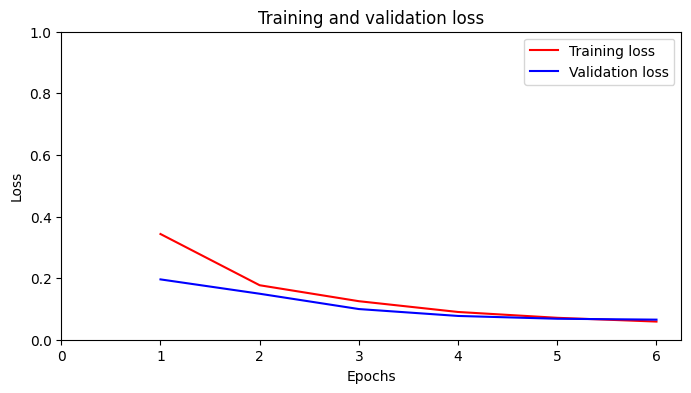

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

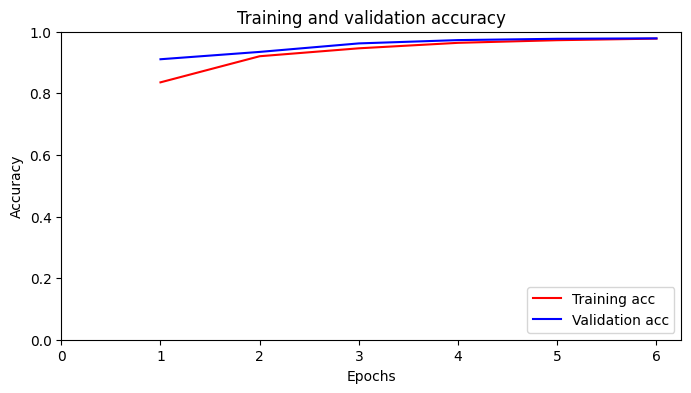

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

# Exporting the model

The model we defined above takes vectors as an input. To simplify deploying it and make the model capable of processing raw string, we include the **vectorize_layer** in the export model.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
])

export_model.compile(loss=losses.BinaryCrossentropy(),
                     optimizer='adam',
                     metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

We can pass the raw string to the NN model. Let's get the model predicts some comments and see the results. The model's output is the probability of the each type of text. For example, hate has 0.95 means the text is 95% a hateful comment.

1/1 [==============================] - 0s 220ms/step
You idiot


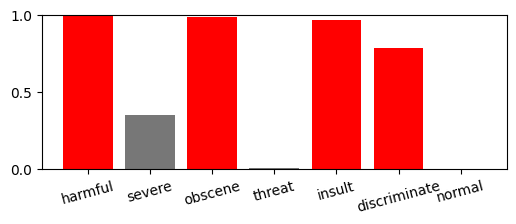

Fuck you


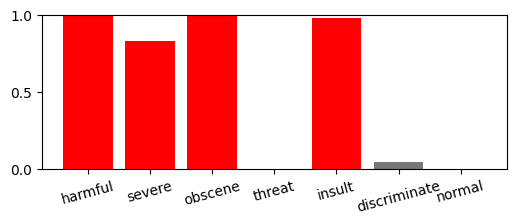

Dear god this site is horrible.


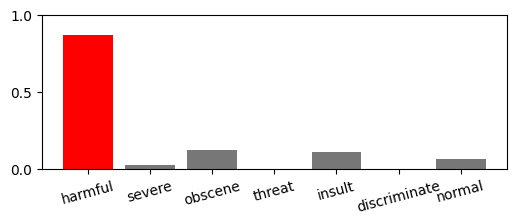

Only a fool can believe in such numbers.


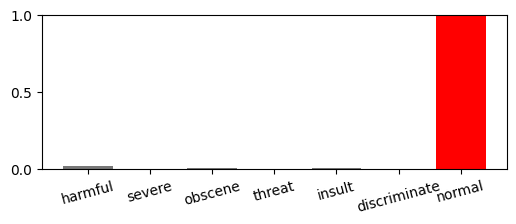

I have indefinitely blocked this account.


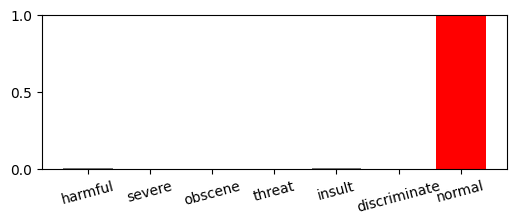

Love the commitment bitch


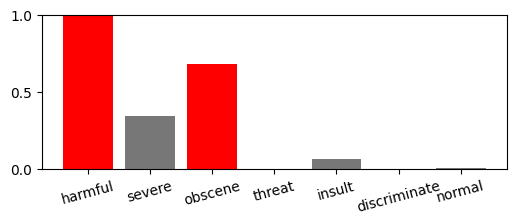

hello how are you


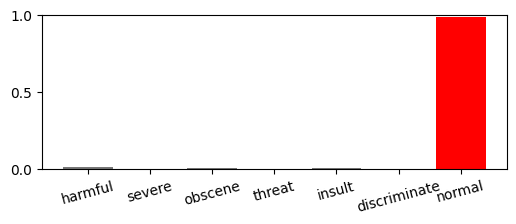

In [ ]:
inputs = [
  "You idiot",
  "Fuck you",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Love the commitment bitch",
  "hello how are you"
]
examples = tf.constant(inputs)

def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = export_model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(6, 2))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()

Lastly, the trained model is saved and ready for deployment.

In [ ]:
export_model.save('drive/MyDrive/saved-models/CNN-model', save_format='tf')
export_model.save('drive/MyDrive/saved-models/CNN-model.keras')

pretrained_model = tf.saved_model.load('drive/MyDrive/saved-models/CNN-model')